In [1]:
import pandas, numpy, seaborn, scipy

In [2]:
import sklearn, sklearn.preprocessing
import statsmodels, statsmodels.stats, statsmodels.stats.multitest

In [3]:
import matplotlib, matplotlib.pyplot
matplotlib.rcParams.update({'font.size':20, 
                            'xtick.labelsize':20, 
                            'ytick.labelsize':20, 
                            'axes.labelsize':20, 
                            'figure.figsize':(12 * 0.8, 9 * 0.8)})

In [4]:
input_data_file = '/Users/adrian/gd15/research/vigur/data/targeted.2024.eva/EC_72_EVA_All_ION_MODES.xlsx'

In [5]:
negativedf = pandas.read_excel(input_data_file, sheet_name='ACID_NEG', index_col='SAMPLE')

# batch & replicate 2

In [6]:
wdf = negativedf[negativedf['LCMS_BATCH'] == 2]

['Pool', 'Pool', 'Pool', 'Pool', 'Pool', 'Pool', 'Pool', 'Pool', 'Pool', 'Pool', 'Pool']
['Pool', 'Pool', 'Pool', 'Pool', 'Pool', 'Pool', 'Pool', 'Pool', 'Pool', 'Pool', 'Pool']


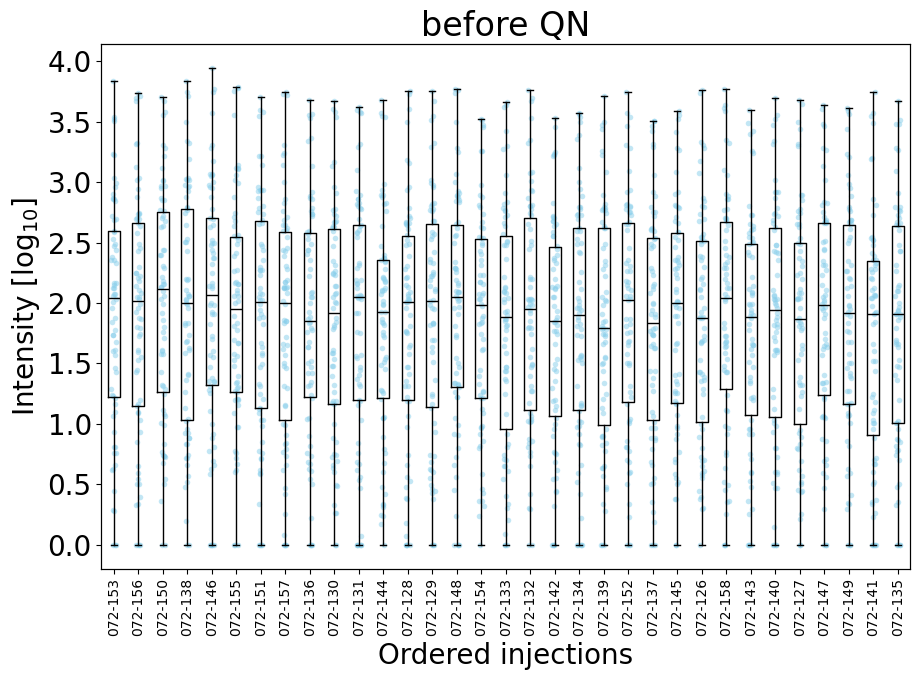

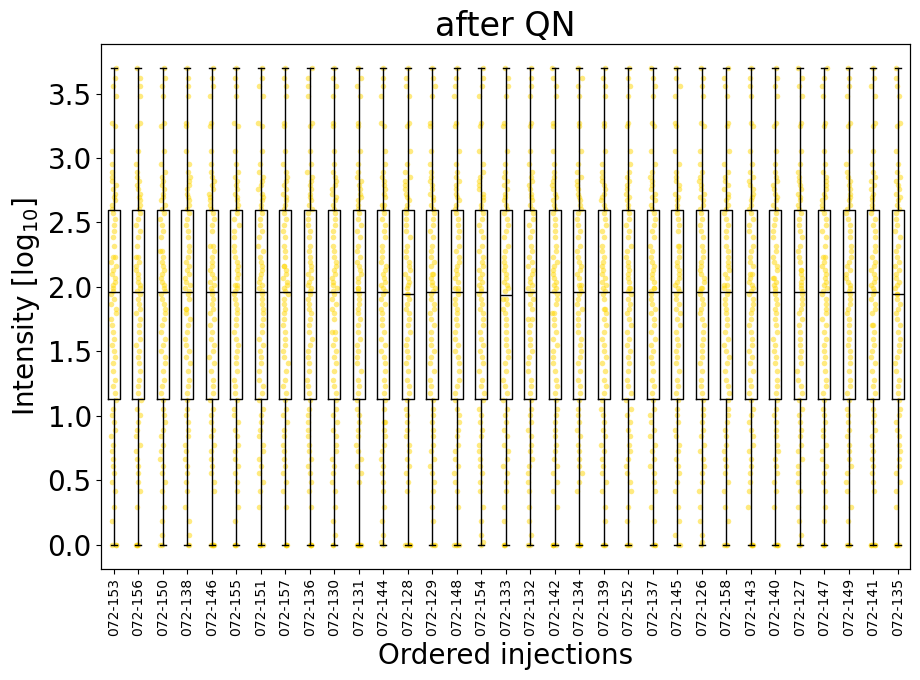

In [7]:
# transform
intensities = wdf.iloc[:, 6:]

rocks = []
for label in wdf.index:
    if isinstance(label, str) == False:
        rocks.append(label)
    else:
        if '072' not in label:
            rocks.append(label)  
print(rocks)
# some rocks that failed
print(rocks)
#
intensities.drop(rocks, axis=0, inplace=True)

intensities = intensities.transpose()
log10_intensities = numpy.log10(intensities + 1)

#plot
ax1 = log10_intensities.boxplot(color='black', grid=False)
ax2 = ax1.twiny()
seaborn.stripplot(log10_intensities, color='skyblue', size=4, alpha=1/2, ax=ax2)
ax2.xaxis.set_visible(False)
ax1.set_zorder(ax2.get_zorder()+1)
ax1.patch.set_visible(False)
ax1.tick_params(axis='x', labelrotation=90, labelsize=10)
ax1.set_xlabel('Ordered injections')
ax1.set_ylabel('Intensity [log$_{10}$]')
matplotlib.pyplot.title('before QN')
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

###
### quantile normalization |  taken from https://cmdlinetips.com/2020/06/computing-quantile-normalization-in-python/
###

# step 1/3: sorting sample values
df_sorted = pandas.DataFrame(numpy.sort(log10_intensities.values, axis=0), 
                             index=log10_intensities.index, 
                             columns=log10_intensities.columns)
# step 2/3: averaging rank values across samples
df_mean = df_sorted.mean(axis=1)
df_mean.index = numpy.arange(1, len(df_mean) + 1)
# step 3/3: re-ordering samples
df_qn = log10_intensities.rank(method="min").stack().astype(int).map(df_mean).unstack()

# plot after
ax1 = df_qn.boxplot(color='black', grid=False)
ax2 = ax1.twiny()
seaborn.stripplot(df_qn, color='gold', size=4, alpha=1/2, ax=ax2)
ax2.xaxis.set_visible(False)
ax1.set_zorder(ax2.get_zorder()+1)
ax1.patch.set_visible(False)
ax1.tick_params(axis='x', labelrotation=90, labelsize=10)
ax1.set_xlabel('Ordered injections')
ax1.set_ylabel('Intensity [log$_{10}$]')
matplotlib.pyplot.title('after QN')
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

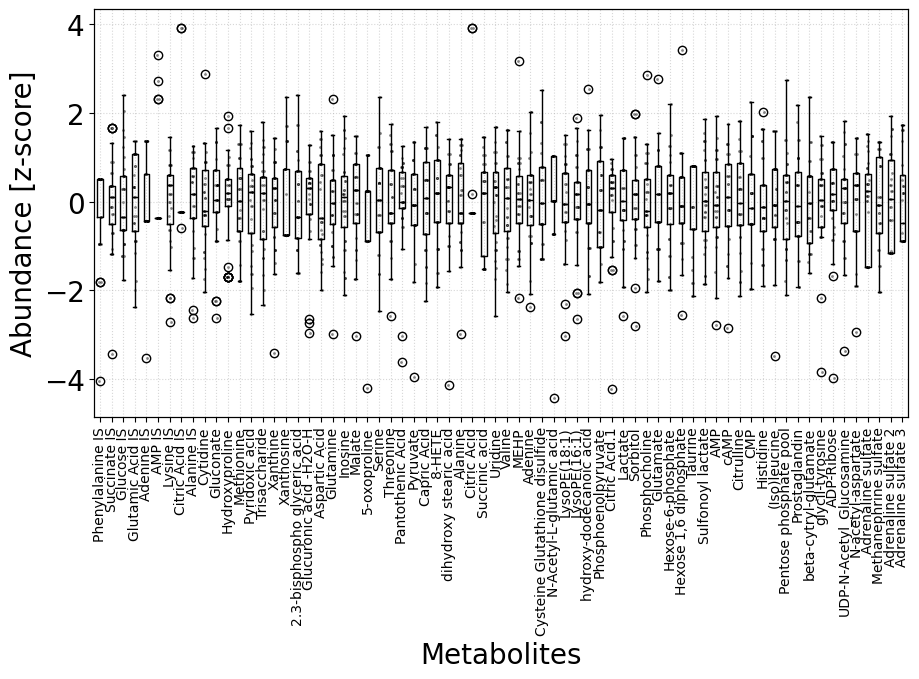

In [8]:
# transpose & scale
t_df_qn = df_qn.transpose()
std_scaler = sklearn.preprocessing.StandardScaler()
df_std = pandas.DataFrame(std_scaler.fit_transform(t_df_qn), columns=t_df_qn.columns, index=t_df_qn.index)

ax1 = df_std.boxplot(color='black', grid=False)
ax2 = ax1.twiny()
seaborn.stripplot(df_std, color='black', size=2, alpha=1/2, ax=ax2)
ax2.xaxis.set_visible(False)
ax1.set_zorder(ax2.get_zorder()+1)
ax1.patch.set_visible(False)
ax1.tick_params(axis='x', labelrotation=90, labelsize=10)
ax1.set_xlabel('Metabolites')
ax1.set_ylabel('Abundance [z-score]')
ax1.grid(True, ls=':', alpha=0.5)
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

In [9]:
print(log10_intensities.loc['AMP IS'].values)
print(df_qn.loc['AMP IS'].values)

[0.         0.         0.         0.         0.         0.
 0.71441359 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.55581968 0.49331861 0.         0.         0.         0.59195456
 0.         0.         0.        ]
[0.         0.         0.         0.         0.         0.
 0.66688116 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.48402565 0.55838297 0.         0.         0.         0.48402565
 0.         0.         0.        ]


In [10]:
print(log10_intensities.loc['Lactate'].values)
print(df_qn.loc['Lactate'].values)

[2.84118735 3.12747962 2.96678214 2.7700032  3.05281394 3.11418215
 2.92884374 3.14238477 2.48650415 2.72237228 2.85958858 2.89351376
 2.7160618  2.82695417 3.06912285 2.89159766 2.78226976 2.80401124
 2.7053419  3.00308165 2.6167548  2.91549956 2.60984616 2.9144262
 2.84307261 3.09647446 2.64084899 2.92179101 2.71065461 3.02033849
 2.98297187 2.72923366 2.67349367]
[2.72346845 3.05229472 2.82232158 2.57722392 2.82232158 3.05229472
 2.79057778 3.05229472 2.48344914 2.79057778 2.82232158 2.95030328
 2.85145464 2.82232158 3.05229472 2.95030328 2.82232158 2.72346845
 2.85145464 2.95030328 2.57722392 2.8944862  2.69647927 2.95030328
 2.8944862  3.05229472 2.82232158 2.95030328 2.75762314 2.95030328
 2.95030328 2.8944862  2.69647927]


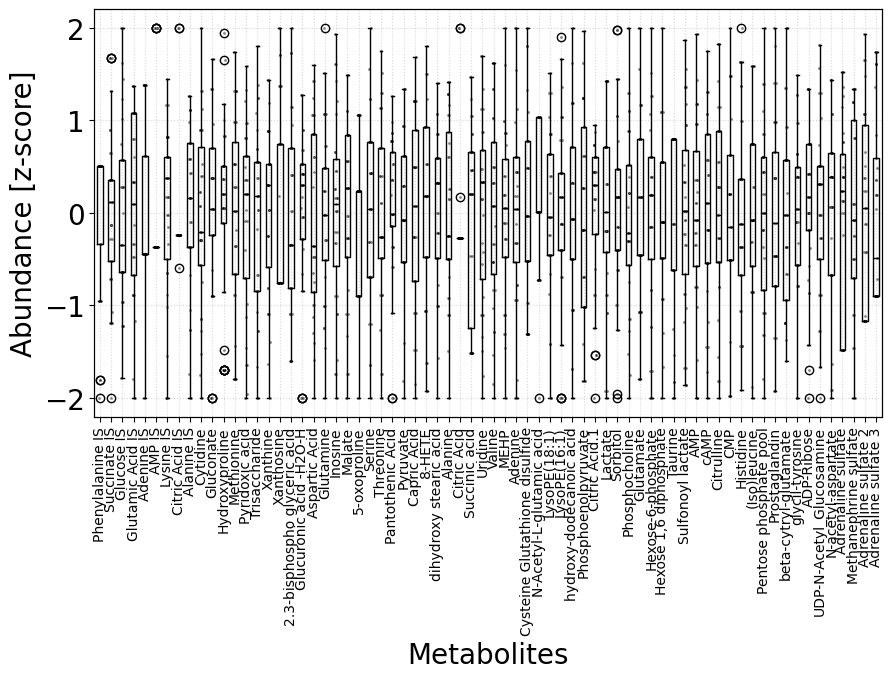

In [11]:
# clip
df_std.clip(-2, 2, inplace=True)

ax1 = df_std.boxplot(color='black', grid=False)
ax2 = ax1.twiny()
seaborn.stripplot(df_std, color='black', size=2, alpha=1/2, ax=ax2)
ax2.xaxis.set_visible(False)
ax1.set_zorder(ax2.get_zorder()+1)
ax1.patch.set_visible(False)
ax1.tick_params(axis='x', labelrotation=90, labelsize=10)
ax1.set_xlabel('Metabolites')
ax1.set_ylabel('Abundance [z-score]')
ax1.grid(True, ls=':', alpha=0.5)
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

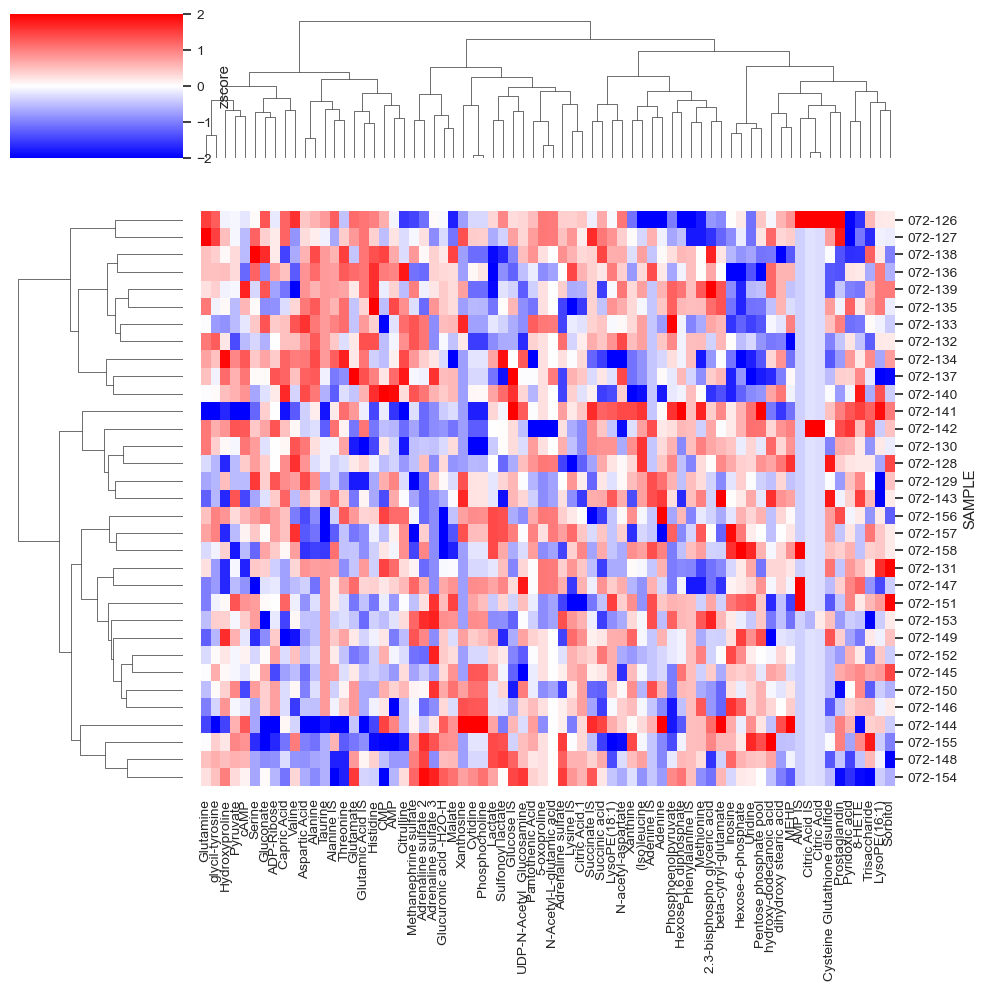

In [12]:
# visualize pattern
linkage_method = 'ward'
distance_metric = 'euclidean'

seaborn.set(font_scale=0.9)
seaborn.clustermap(df_std, 
                   cmap='bwr', col_cluster=True, vmin=-2, vmax=2, 
                   method=linkage_method, metric=distance_metric, 
                   yticklabels=1, xticklabels=1,
                   cbar_kws={'label':'zscore'})
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

seaborn.reset_orig()

In [13]:
print(df_std['Alanine IS'].mean())
print(df_std['Alanine IS'].std())

0.03289056070359405
0.9357550960715625


Timepoint 4
Pyridoxic acid
Glucuronic acid -H2O-H
Uridine
Valine
Hexose-6-phosphate
Hexose 1,6 diphosphate
Histidine
N-acetyl-aspartate
Methanephrine sulfate
Adrenaline sulfate 2
We found significant metabolites: 0
(array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False]), array([0.90664161, 0.90664161, 0.99933   , 0.55504734, 0.90664161,
       1.        , 0.90664161, 1.        , 0.99933   , 0.99933   ,
       0.85966147, 0.90664161, 0.90664161, 0.27915918, 0.90664161,
       0.73467122, 0.99933   , 0.90

/Users/adrian/anaconda3/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
/Users/adrian/anaconda3/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
/Users/adrian/anaconda3/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
/Users/adrian/anaconda3/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531

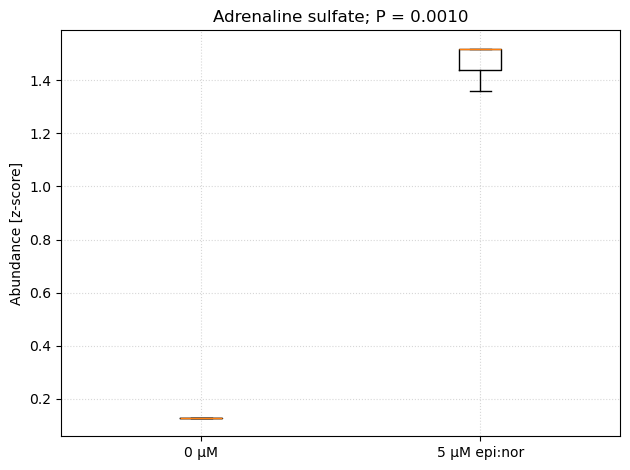

Adrenaline sulfate 2 0.02771275150092029


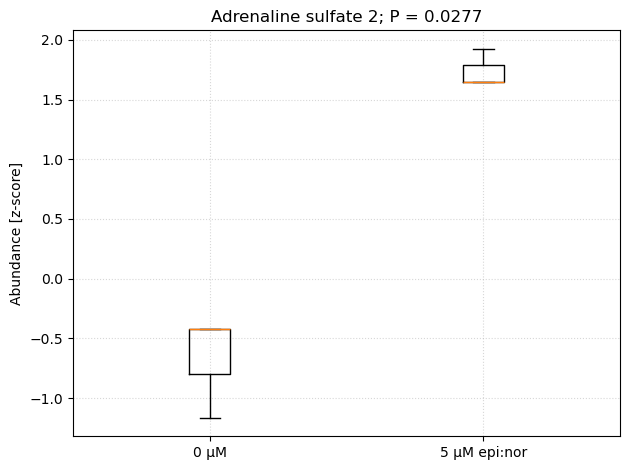

In [14]:
# test
timepoints = [4, 24]
timepoints = [4, 24]
control_label = '0µM'
sample_label = '5 µM epi:nor'
metabolites = df_std.columns

for timepoint in timepoints:
    print('Timepoint {}'.format(timepoint))
    rules = (wdf['TIME'] == timepoint) & (wdf['TREATMENT'] == control_label)
    controls = wdf[rules].index.to_list()
    rules = (wdf['TIME'] == timepoint) & (wdf['TREATMENT'] == sample_label)
    samples = wdf[rules].index.to_list()

    uncorrected = []
    for metabolite in metabolites:
        #print('\t', metabolite)
        existing = [control for control in controls if control in df_std.index]
        x = df_std.loc[existing, metabolite]
        existing = [sample for sample in samples if sample in df_std.index]
        y = df_std.loc[samples, metabolite]

        (statistic, pvalue) = scipy.stats.ttest_ind(x, y)
        if numpy.isnan(pvalue) == True:
            pvalue = 1
        uncorrected.append(pvalue)
        if pvalue < 0.05:
            print(metabolite)
    results = statsmodels.stats.multitest.multipletests(uncorrected, method='fdr_bh')
    print('We found significant metabolites:', sum(results[0]))
    print(results)

    # plot significant
    for i in range(len(metabolites)):
        if results[0][i] == True:
            print(metabolites[i], results[1][i])
            metabolite = metabolites[i]
            a = df_std.loc[controls, metabolite]
            b = df_std.loc[samples, metabolite]
            matplotlib.pyplot.boxplot([a, b])
            matplotlib.pyplot.title('{}; P = {:.4f}'.format(metabolite, results[1][i]))
            matplotlib.pyplot.xticks([1, 2], ['0 µM', '5 µM epi:nor'])
            matplotlib.pyplot.ylabel('Abundance [z-score]')
            matplotlib.pyplot.grid(ls=':', alpha=0.5)
            matplotlib.pyplot.tight_layout()
            matplotlib.pyplot.show()